# Decision Trees from Scratch

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier as SklearnDecisionTree
import matplotlib.pyplot as plt
import seaborn as sns

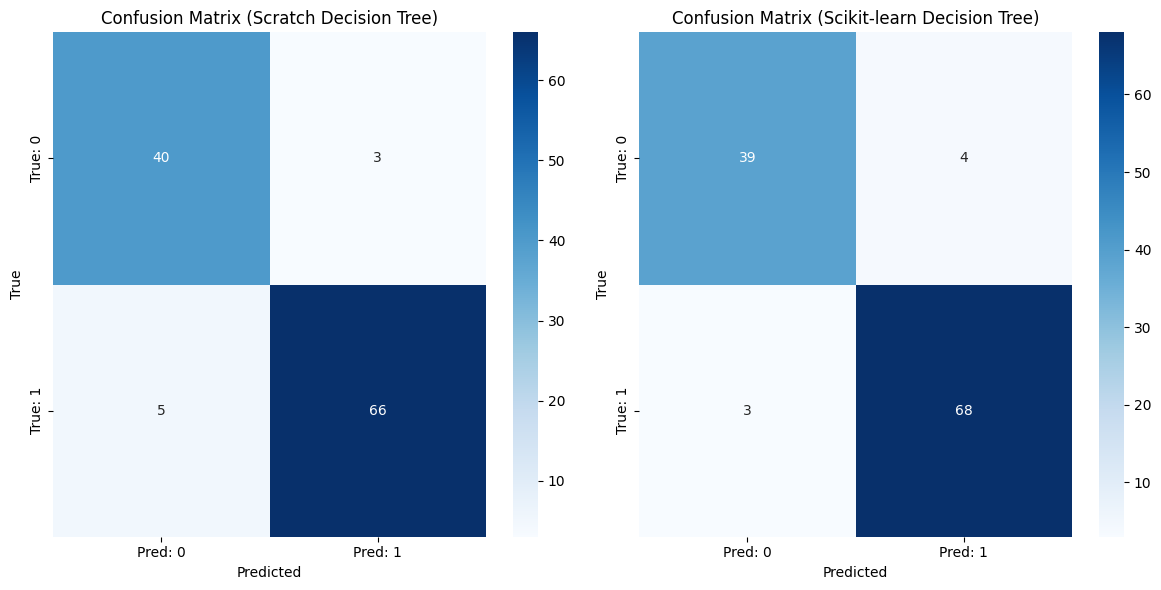

In [7]:
class DecisionTreeScratch:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def _gini(self, y):
        classes = np.unique(y)
        gini = 1.0
        for c in classes:
            p = np.sum(y == c) / len(y)
            gini -= p ** 2
        return gini

    def _split(self, X, y, feature_index, threshold):
        left_mask = X[:, feature_index] <= threshold
        right_mask = ~left_mask
        return X[left_mask], X[right_mask], y[left_mask], y[right_mask]

    def _best_split(self, X, y):
        best_gini = float('inf')
        best_feature = None
        best_threshold = None
        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                X_left, X_right, y_left, y_right = self._split(X, y, feature_index, threshold)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                gini_left = self._gini(y_left)
                gini_right = self._gini(y_right)
                gini = (len(y_left) * gini_left + len(y_right) * gini_right) / len(y)
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature_index
                    best_threshold = threshold
        return best_feature, best_threshold

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if depth >= self.max_depth or num_labels == 1 or num_samples == 0:
            leaf_value = self._most_common_label(y)
            return {"leaf": leaf_value}

        feature_index, threshold = self._best_split(X, y)
        if feature_index is None:
            leaf_value = self._most_common_label(y)
            return {"leaf": leaf_value}

        X_left, X_right, y_left, y_right = self._split(X, y, feature_index, threshold)
        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)
        return {"feature_index": feature_index, "threshold": threshold, "left": left_subtree, "right": right_subtree}

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, 0)

    def _traverse_tree(self, x, tree):
        if "leaf" in tree:
            return tree["leaf"]
        feature_index = tree["feature_index"]
        threshold = tree["threshold"]
        if x[feature_index] <= threshold:
            return self._traverse_tree(x, tree["left"])
        return self._traverse_tree(x, tree["right"])

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

# load dataset
data = load_breast_cancer()
X = data.data  # Features
y = data.target  # Labels

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train Decision Tree from scratch
dec_tree_scratch = DecisionTreeScratch(max_depth=5)
dec_tree_scratch.fit(X_train, y_train)
y_pred_scratch_tree = dec_tree_scratch.predict(X_test)

# train Decision Tree using scikit-learn
dec_tree_sklearn = SklearnDecisionTree(max_depth=5)
dec_tree_sklearn.fit(X_train, y_train)
y_pred_sklearn_tree = dec_tree_sklearn.predict(X_test)

# compute cm for both models
cm_scratch_tree = confusion_matrix(y_test, y_pred_scratch_tree)
cm_sklearn_tree = confusion_matrix(y_test, y_pred_sklearn_tree)

# plot cm
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# scratch decision tree confusion matrix
sns.heatmap(cm_scratch_tree, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'], ax=axs[0])
axs[0].set_title('Confusion Matrix (Scratch Decision Tree)')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')

# scikit-learn decision tree confusion matrix
sns.heatmap(cm_sklearn_tree, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'], ax=axs[1])
axs[1].set_title('Confusion Matrix (Scikit-learn Decision Tree)')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')

plt.tight_layout()
plt.show()